In [1]:
from dlem.feature_extraction import extractor
import dlem.util as util
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
import cooler
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

/Users/tina/miniforge3/envs/dlem_env/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


<Figure size 640x480 with 0 Axes>

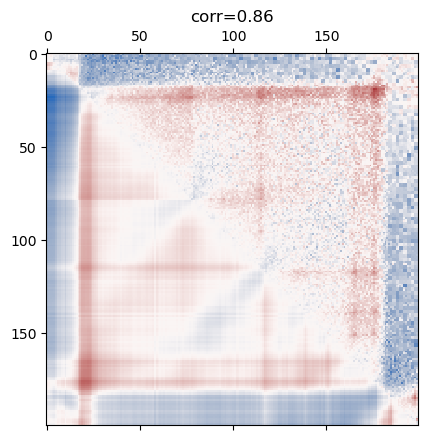

In [2]:
def weighted_mse(input, target, weight=None):
    if weight is None:
        weight = torch.exp(target)
    return torch.mean(weight * (input - target) ** 2)

def wMSE_weight(weight_matrix):
    return weight_matrix

weights = wMSE_weight

locus = 'chr10:3000000-5000000' # 'chr10:20500000-22500000'
res = '10000'
lr = 0.5
num_epoch = 100
detach = {'10000':0.025,
          '5000':0.00125,
          '2000':0.005}

cell_line = 'H1hESC' 
cool_filename = '/Users/tina/LoopExtrusion/data/H1.mcool'
h5 = h5py.File(cool_filename, 'r')
cool = cooler.Cooler(h5['resolutions'][res])

model_name = 'minimal_dlem'

diag_start= 5 * int(10_000/int(res))
diag_stop= 120 * int(10_000/int(res))
depth = 10 * int(10_000/int(res))

res = int(res)
'''
depth above 10 (or 20) for 'chr10:3000000-5000000' significantly reduces the quality of the fit. it just spits out nonsense. 
--> it must have sth to do with the fact that also the starting diagonal is very very noisy. 
'''

patch_coarsegrain = adaptive_coarsegrain(cool.matrix(balance=True).fetch(locus), cool.matrix(balance=False).fetch(locus), cutoff=3, max_levels=8)
patch_coarsegrain_interpolated = interp_nan(patch_coarsegrain)               
patch = np.exp(util.diagonal_normalize(np.log( patch_coarsegrain_interpolated[np.newaxis]) ))

out = extractor(util.diagonal_normalize(np.log(patch))[0],
                                res=res,
                                learning_rate=lr,
                                arch=model_name,
                                diag_start=diag_start,
                                diag_stop=diag_stop,
                                depth=depth,
                                num_epoch = num_epoch,
                                loss=weighted_mse,  # you have to see where it's defined, because it's different. 
                                weights=weights(patch),
                                dev_name='cpu', do_plot=True)

params, corr = out
L, R = params




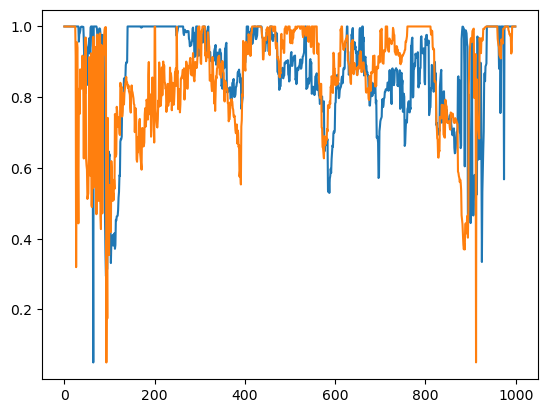

In [32]:
plt.plot(L)
plt.plot(R)

In [8]:
L, R = params